*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Text Classification of MultiNLI Sentences using Multiple Transformer Models  


#### TODO
1. Make sure that all the packages can be installed on Colab


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Import requirements

In [14]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'scikit-learn', 'numpy', 'scrapbook',
            'pandas', 'matplotlib',
            'transformers==2.10.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


In [16]:
import json
import os
import pickle
import shutil
import sys
import tempfile
import urllib
import zipfile
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scrapbook as sb
import torch
import torch.nn as nn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from spacy.lang.en import English
from tqdm import tqdm

# Our code components
from common.article_classification_dataset import (
    ArticleClassificationDataProcessor,
    ArticleClassificationDataSet,
)
from common.article_classification_model import ArticleClassifier
from common.article_classification_utilities import DownloadMindDataset, Timer


In [18]:
# !python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

In [19]:
# notebook parameters
CACHE_DIR = TemporaryDirectory().name
NUM_EPOCHS = 1
BATCH_SIZE = 32
NUM_GPUS = torch.cuda.device_count()
MAX_LEN = 100
MODEL_NAMES = ["distilbert-base-uncased", "roberta-base", "xlnet-base-cased"]
MODEL_RESULTS = dict()
LABEL_COL = 'category'
TEXT_COL = 'text'

## Read the files with pandas  
 The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
 It has 7 columns, which are divided by the tab symbol:
 - News ID
 - Category
 - Subcategory
 - Title
 - Abstract
 - URL
 - Title Entities (entities contained in the title of this news)
 - Abstract Entities (entities contained in the abstract of this news)

### Download and Process MIND Dataset  

Using `DownloadMindDataset.process_and_load_dfs()` returns the training and test dataframes.  

> - Using defaults sets the data directory to `mind_dataset` and downloads small set
> - If the data is already downloaded, the download process is skipped


In [20]:
df_train, df_test = DownloadMindDataset.process_and_load_dfs()

Train:  ['entity_embedding.vec', 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip', 'relation_embedding.vec', 'news.tsv', 'behaviors.tsv']
Test:  ['entity_embedding.vec', 'relation_embedding.vec', 'news.tsv', 'behaviors.tsv', 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip']


In [21]:
display(df_train.head())
display(df_train.head())

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [22]:
display(df_train.shape)
display(df_test.shape)

(51282, 8)

(42416, 8)

## Functions

## Introduction
In this notebook, we fine-tune and evaluate a number of pretrained models on a subset of the [Microsoft MIND Dataset](https://blogs.msn.com/mind-at-work-news-recommendation-challenge-for-researchers/) dataset.

We use a `ArticleClassifier` that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/transformers) of different transformers, like [BERT](https://github.com/google-research/bert), [XLNet](https://github.com/zihangdai/xlnet), and [RoBERTa](https://github.com/pytorch/fairseq).  

It also adapts some of the work done on [Microsoft NLP Recipes](https://github.com/microsoft/nlp) to implement the `ArticleClassifier` and other reusable components that make it easy to fit these transfomer models.  

We leveraged Hugging Face's latest `AutoModels` architecture to help us infer the different transformer models we used for this article classification.  

We fine-tuned the transformer models on Microsoft Azure GPU machines with a configuration of 1 Tesla K80 GPU with 56 GiB RAM. 


## Read Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The MultiNLI dataset is mainly used for natural language inference (NLI) tasks, where the inputs are sentence pairs and the labels are entailment indicators. The sentence pairs are also classified into *genres* that allow for more coverage and better evaluation of NLI models.

For our classification task, we use the first sentence only as the text input, and the corresponding genre as the label. We select the examples corresponding to one of the entailment labels (*neutral* in this case) to avoid duplicate rows, as the sentences are not unique, whereas the sentence pairs are.

In [23]:
df_train = df_train[["title", "abstract", "category"]]
df_test = df_test[["title", "abstract", "category"]]

In [24]:
display(df_train.isnull().sum())

title          0
abstract    2666
category       0
dtype: int64

In [25]:
display(df_test.isnull().sum())

title          0
abstract    2021
category       0
dtype: int64

Exploring the data, we observed that there are rows with NaN. This is interesting, because you would expect that from a numerical data and not text. However, we need to spend some time data wrangling and cleaning.  

1. First, we remove the rows with Nan
1. To avoid scrapping the entire news article with their links, we decided to use a combination of the news title and abstract, from the MIND dataset, as the full text to train our classifiers
1. There is a category of article called `news`. We decided to choose the top unique 6 categories removing the `news` category.

In [26]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [27]:
display(df_train.isnull().sum())

title       0
abstract    0
category    0
dtype: int64

In [28]:
display(df_test.isnull().sum())

title       0
abstract    0
category    0
dtype: int64

In [29]:
display(df_train.shape)
display(df_test.shape)

(48616, 3)

(40395, 3)

### Merging the title and abstract to form long enough text to finetune our classifier

In [30]:
df_train["text"] = df_train["title"].astype(str) + df_train["abstract"].astype(str)
df_train.drop(columns=['title', 'abstract'], inplace=True)

In [31]:
display(df_train.head())
display(df_train.shape)

,category,text
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,health,50 Worst Habits For Belly FatThese seemingly h...
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."


(48616, 2)

In [32]:
df_test["text"] = df_test["title"].astype(str) + df_test["abstract"].astype(str)
df_test.drop(columns=['title', 'abstract'], inplace=True)

In [33]:
display(df_test.head())
display(df_test.shape)

,category,text
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."
5,sports,Should NFL be able to fine players for critici...


(40395, 2)

### Filter the data to only interesting article types 

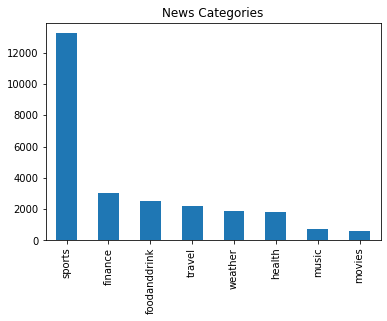

In [42]:
# Distribution of the categories
df_train.category.value_counts().plot.bar(title="News Categories");

In [34]:
# Choose top interesting categories
chosen_articles = [
    "sports",
    "finance",
    "foodanddrink",
    "health",
    "travel",
    "weather",
    "movies",
    "music",
]

In [35]:
display(df_train.shape)
df_train = df_train[df_train.category.isin(chosen_articles)]

(48616, 2)

In [36]:
display(df_test.shape)
df_test = df_test[df_test.category.isin(chosen_articles)]

(40395, 2)

In [37]:
# shuffle and reset index
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [38]:
display(df_train.head(10))
display(df_train.shape)

,category,text
0,sports,UW quarterback Jack Coan was perfect on third ...
1,health,13 Signs You Need to See a Dentist Right AwayD...
2,health,How John Gramlich Changed His Diet and Trainin...
3,sports,"Day in 'extremely critical condition,' accordi..."
4,sports,Jacoby Brissett says having Andrew Luck around...
5,sports,Daily Slop: Redskins Media Links RoundupA coll...
6,sports,Wisconsin's career rushing record falls; Racin...
7,sports,Greg Hardy doesn't expect any praise in his ca...
8,sports,Zozo Championship: Tiger Woods overcomes 'very...
9,sports,"The Day in Sports: Wednesday, October 30, 2019..."


(26084, 2)

In [39]:
display(df_test.head(10))
display(df_test.shape)

,category,text
0,sports,Locked On Suns Monday: Phoenix finally has a c...
1,sports,Hedman hopes to play for Tampa Bay against Sab...
2,health,Celebrity trainer Anna Kaiser's 5 daily non-ne...
3,finance,"Man left his wife nothing, and her stepchildre..."
4,health,Does Intermittent Fasting Work for Weight Loss...
5,sports,"College football Week 7 primer: Heisman Watch,..."
6,movies,Christian Bale went to school in Chandler for ...
7,sports,5 keys to victory for the Seahawks on the road...
8,finance,The wrong kind of stocks are leading the stock...
9,travel,2 restaurants and a retail shop will open at B...


(21461, 2)

The examples in the dataset are grouped into 8 news article category

In [40]:
df_train[LABEL_COL].value_counts()

sports          13231
finance          3048
foodanddrink     2513
travel           2223
weather          1879
health           1834
music             754
movies            602
Name: category, dtype: int64

In [41]:
df_test[LABEL_COL].value_counts()

sports          10778
finance          2533
foodanddrink     2213
travel           1755
health           1676
weather          1364
music             605
movies            537
Name: category, dtype: int64

## Exploratory Data Analysis

### Defining a tokenizer 

Pipeline to remove stop words, urls, punct and lammatize words


In [44]:

def better_tokenizer(doc, model=en):
  return [x.lemma_.lower() for x in en(doc) if (x.is_alpha)&
          (not x.like_url)&(not x.is_punct)&(not x.is_stop)]

Creating tokenized representation 


In [46]:
news_data = [better_tokenizer(str(d)) for d in df_train['text']]

In [47]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2) 
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2)

In [50]:
# **important** just fit on trained: prevents information from test in training 
cv_vecs = cv.fit_transform(news_data).toarray()
tfidf_vecs = tfidf.fit_transform(news_data).toarray()


# get out the vocab (same for tfidf)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 23012


In [51]:
display(cv_vecs.shape)
display(tfidf_vecs.shape)

(26084, 23012)

(26084, 23012)

### Top words for each news category articles (Counts and TF-IDF)

In [53]:
# get top x words
top_words = 10


# Getting the correct index for rows in the train dataset. The original index are kept intact and not reset.

categories_rows_indx = []

for category in chosen_articles:
    categories_rows_indx.append((category, df_train.index[df_train['category'] == category].tolist()))

In [54]:
for vectorizer, vecs  in [(cv, cv_vecs), (tfidf, tfidf_vecs)]:
    print(f"Top {top_words} words using {vectorizer.__class__.__name__}")
    for category, indx in categories_rows_indx:    
        # sum counts
        s_sum = vecs[indx].sum(axis=0)
        # sort arguments
        s_sorted = np.argsort(s_sum)
        # print top words
        print(f"{category} category")
        print([vectorizer.get_feature_names()[x] for x in s_sorted[-top_words:]])
    print("\n")

Top 10 words using CountVectorizer
sports category
['nfl', 'night', 'state', 'new', 'win', 'football', 'team', 'week', 'season', 'game']
finance category
['money', 'trade', 'state', 'city', 'said', 'million', 'home', 'company', 'year', 'new']
foodanddrink category
['restaurants', 'holiday', 'taste', 'home', 'recipes', 'restaurant', 'thanksgiving', 'best', 'food', 'new']
health category
['flu', 'says', 'help', 'study', 'said', 'people', 'weight', 'cancer', 'new', 'health']
travel category
['fire', 'county', 'flight', 'day', 'world', 'airport', 'best', 'said', 'city', 'new']
weather category
['new', 'temperatures', 'area', 'morning', 'storm', 'cold', 'said', 'snow', 'fire', 'weather']
movies category
['films', 'hollywood', 'actor', 'million', 'movies', 'star', 'new', 'trailer', 'movie', 'film']
music category
['cma', 'john', 'year', 'band', 'singer', 'awards', 'country', 'tour', 'new', 'music']


Top 10 words using TfidfVectorizer
sports category
['night', 'patriots', 'state', 'nfl', 'wi

### Analyzing with Tpoic Modeling

In [56]:
n_components=8

nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

# tfidf for nmf
nmf_vecs = nmf.fit_transform(tfidf_vecs)
# count for lda
lda_vecs = lda.fit_transform(cv_vecs)

Topic model performance


In [57]:
print('NMF Reconstruction err:', nmf.reconstruction_err_)
print('LDA ELBO:', lda.bound_)

NMF Reconstruction err: 159.6482406321735
LDA ELBO: 5352.064189078963


Topic model top 10 words


In [60]:
def display_components(model, word_features, top_display=8):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [61]:
print('Displaying top 10 words in each topic using NMF(tfidf): ')
display_components(nmf, tfidf.get_feature_names())

print('\n')

print('Displaying top 10 words in each topic using LDA(CountVectorizer): ')
display_components(lda, cv.get_feature_names())

Displaying top 10 words in each topic using NMF(tfidf): 
Topic 0:
game season win night sunday team chiefs injury
Topic 1:
weather today forecast snow cold temperatures winter record
Topic 2:
world series astros nationals game washington houston yankees
Topic 3:
football state college michigan school high playoff penn
Topic 4:
week nfl steelers power rankings teams highlights bye
Topic 5:
patriots new england brady tom ravens belichick nfl
Topic 6:
best thanksgiving new food recipes city holiday year
Topic 7:
fire said county california firefighters winds near people


Displaying top 10 words in each topic using LDA(CountVectorizer): 
Topic 0:
injury game eagles sunday night week season vikings
Topic 1:
game world season series team astros new win
Topic 2:
weather snow cold season day week storm winter
Topic 3:
best year ufc time lakers city james new
Topic 4:
week football game state season win team nfl
Topic 5:
new says city like food help years said
Topic 6:
thanksgiving new recipes

##  Fitting SVM models for TFIDF, CV, NMF, LDA and Glove vectors

Data prep for SVM Training


In [59]:
X_train_text = df_train['text']
y_train = df_train['category']
X_test_text = df_test['text']
y_test = df_test['category']

Initialize models/vectorizers to use


In [ ]:

n_components=8

svc = LinearSVC()
tfidf = TfidfVectorizer(tokenizer=better_tokenizer, min_df=2)
cv = CountVectorizer(tokenizer=better_tokenizer, min_df=2)
nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

Generate different vectors

In [62]:
# TFIDF featureset
tfidf_train = tfidf.fit_transform(X_train_text)
tfidf_test = tfidf.transform(X_test_text)

# CV featureset
cv_train = cv.fit_transform(X_train_text)
cv_test = cv.transform(X_test_text)


# NMF featureset
nmf_train = nmf.fit_transform(tfidf_train)
nmf_test = nmf.transform(tfidf_test)


# Glove featureset
glove_train = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_train_text])
glove_test = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_test_text])

### Fit SVC with all the vectors

In [ ]:
# fit/predict on full dataset
svc = LinearSVC(max_iter=10000)
for pair in [(tfidf_train, tfidf_test, "tfidf"),
             (cv_train, cv_test, "cv"),
            (nmf_train, nmf_test, "nmf"),
            (glove_train, glove_test, "glove"),
            ]:
    svc.fit(pair[0], y_train)
    preds_test = svc.predict(pair[1])
    preds_train = svc.predict(pair[0])
    acc_train = accuracy_score(y_train, preds_train)
    acc_test = accuracy_score(y_test, preds_test)
    

    class_report = classification_report(y_test, preds_test, output_dict=True)

    MODEL_RESULTS[pair[2]] = {
        "Test Set Accuracy": acc_test,
        "f1-score": class_report["macro avg"]["f1-score"],
    }
    
    print(f"{pair[2]} Train acc : ",acc_train)
    print(f"{pair[2]} Test acc : ",acc_test)
    print("\n")

tfidf Train acc :  0.5732249654960896
tfidf Test acc :  0.5708960439867667




In [65]:
MODEL_RESULTS

{'tfidf': {'Test Set Accuracy': 0.5709426401379246,
  'f1-score': 0.27670403829361345},
 'cv': {'Test Set Accuracy': 0.5173104701551652,
  'f1-score': 0.12373026595704814},
 'nmf': {'Test Set Accuracy': 0.5012347980056847,
  'f1-score': 0.08608489719037418},
 'glove': {'Test Set Accuracy': 0.9061087554168026,
  'f1-score': 0.8568215170129774}}

# NN Models

In [98]:

label_encoder = LabelEncoder()
df_train[LABEL_COL] = label_encoder.fit_transform(df_train[LABEL_COL])
df_test[LABEL_COL] = label_encoder.transform(df_test[LABEL_COL])

num_labels = len(np.unique(df_train[LABEL_COL]))

In [99]:
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 8
Number of training examples: 26084
Number of testing examples: 21461


In [100]:
display( len(np.unique(df_train[LABEL_COL])))
display( len(np.unique(df_test[LABEL_COL])))

8

8

## Select Pretrained Models

Several pretrained models have been made available by [Hugging Face](https://github.com/huggingface/transformers). For text classification. We will be using `distillBert, Roberta` and `XLNet` because of their size compared to other larger transformer models.  


## Fine-tune

Our wrappers make it easy to fine-tune different models in a unified way, hiding the preprocessing details that are needed before training. In this example, we're going to select the following models and use the same piece of code to fine-tune them on our genre classification task. Note that some models were pretrained on multilingual datasets and can be used with non-English datasets.

In [103]:
print(MODEL_NAMES)

['distilbert-base-uncased', 'roberta-base', 'xlnet-base-cased']


For each pretrained model, we preprocess the data, fine-tune the classifier, score the test set, and store the evaluation results.

In [38]:
for name in tqdm(MODEL_NAMES[:1], disable=True):

    # preprocess
    processor = ArticleClassificationDataProcessor(
        model_name=str(name),
        to_lower=name.endswith("uncased"),
        batch_size=BATCH_SIZE, 
        num_gpus=NUM_GPUS,
        cache_dir=CACHE_DIR
    )
    
    # Defining training artifacts
    train_dataset = processor.create_dataset_from_dataframe(df_train, TEXT_COL, LABEL_COL, max_len=MAX_LEN)
    train_dataloader = processor.create_dataloader_from_dataset(train_dataset, shuffle=True)
    
    # Defining test artifacts
    test_dataset = processor.create_dataset_from_dataframe(df_test, TEXT_COL, LABEL_COL, max_len=MAX_LEN)
    test_dataloader = processor.create_dataloader_from_dataset(test_dataset, shuffle=False)

    # fine-tune
    classifier = ArticleClassifier(model_name=name, num_labels=num_labels, cache_dir=CACHE_DIR)
    with Timer() as t:
        classifier.fit(
            train_dataloader, num_epochs=NUM_EPOCHS, num_gpus=NUM_GPUS, verbose=False,
        )
    train_time = t.interval / 3600

    # predict
    preds = classifier.predict(test_dataloader, num_gpus=NUM_GPUS, verbose=True)

    # eval
    accuracy = accuracy_score(df_test[LABEL_COL], preds)
    class_report = classification_report(
        df_test[LABEL_COL], preds, target_names=label_encoder.classes_, output_dict=True
    )

    # save results
    MODEL_RESULTS[name] = {
        "Test Set Accuracy": accuracy,
        "f1-score": class_report["macro avg"]["f1-score"],
        "time(hrs)": train_time,
    }

Iteration:   2%|▏         | 10/408 [00:05<03:27,  1.92it/s]

timestamp: 07/08/2020 01:13:26, average loss: 1.687456, time duration: 5.396389,
                            number of examples in current reporting: 320, step 10
                            out of total 408


Iteration:   5%|▍         | 20/408 [00:10<03:20,  1.94it/s]

timestamp: 07/08/2020 01:13:31, average loss: 1.170485, time duration: 5.141245,
                            number of examples in current reporting: 320, step 20
                            out of total 408


Iteration:   7%|▋         | 30/408 [00:15<03:13,  1.96it/s]

timestamp: 07/08/2020 01:13:36, average loss: 0.865737, time duration: 5.118764,
                            number of examples in current reporting: 320, step 30
                            out of total 408


Iteration:  10%|▉         | 40/408 [00:20<03:07,  1.97it/s]

timestamp: 07/08/2020 01:13:41, average loss: 0.831665, time duration: 5.098286,
                            number of examples in current reporting: 320, step 40
                            out of total 408


Iteration:  12%|█▏        | 50/408 [00:25<03:06,  1.92it/s]

timestamp: 07/08/2020 01:13:47, average loss: 0.654620, time duration: 5.149658,
                            number of examples in current reporting: 320, step 50
                            out of total 408


Iteration:  15%|█▍        | 60/408 [00:31<02:57,  1.96it/s]

timestamp: 07/08/2020 01:13:52, average loss: 0.538452, time duration: 5.108948,
                            number of examples in current reporting: 320, step 60
                            out of total 408


Iteration:  17%|█▋        | 70/408 [00:36<02:53,  1.95it/s]

timestamp: 07/08/2020 01:13:57, average loss: 0.535440, time duration: 5.130575,
                            number of examples in current reporting: 320, step 70
                            out of total 408


Iteration:  20%|█▉        | 80/408 [00:41<02:50,  1.93it/s]

timestamp: 07/08/2020 01:14:02, average loss: 0.447491, time duration: 5.156112,
                            number of examples in current reporting: 320, step 80
                            out of total 408


Iteration:  22%|██▏       | 90/408 [00:46<02:44,  1.93it/s]

timestamp: 07/08/2020 01:14:07, average loss: 0.340346, time duration: 5.201230,
                            number of examples in current reporting: 320, step 90
                            out of total 408


Iteration:  25%|██▍       | 100/408 [00:51<02:40,  1.92it/s]

timestamp: 07/08/2020 01:14:12, average loss: 0.363850, time duration: 5.206596,
                            number of examples in current reporting: 320, step 100
                            out of total 408


Iteration:  27%|██▋       | 110/408 [00:56<02:34,  1.93it/s]

timestamp: 07/08/2020 01:14:18, average loss: 0.368781, time duration: 5.192818,
                            number of examples in current reporting: 320, step 110
                            out of total 408


Iteration:  29%|██▉       | 120/408 [01:02<02:30,  1.91it/s]

timestamp: 07/08/2020 01:14:23, average loss: 0.415847, time duration: 5.224649,
                            number of examples in current reporting: 320, step 120
                            out of total 408


Iteration:  32%|███▏      | 130/408 [01:07<02:25,  1.91it/s]

timestamp: 07/08/2020 01:14:28, average loss: 0.363152, time duration: 5.218906,
                            number of examples in current reporting: 320, step 130
                            out of total 408


Iteration:  34%|███▍      | 140/408 [01:12<02:19,  1.92it/s]

timestamp: 07/08/2020 01:14:33, average loss: 0.386361, time duration: 5.218870,
                            number of examples in current reporting: 320, step 140
                            out of total 408


Iteration:  37%|███▋      | 150/408 [01:17<02:13,  1.93it/s]

timestamp: 07/08/2020 01:14:38, average loss: 0.457655, time duration: 5.196765,
                            number of examples in current reporting: 320, step 150
                            out of total 408


Iteration:  39%|███▉      | 160/408 [01:23<02:09,  1.92it/s]

timestamp: 07/08/2020 01:14:44, average loss: 0.500720, time duration: 5.236064,
                            number of examples in current reporting: 320, step 160
                            out of total 408


Iteration:  42%|████▏     | 170/408 [01:28<02:04,  1.91it/s]

timestamp: 07/08/2020 01:14:49, average loss: 0.383316, time duration: 5.224211,
                            number of examples in current reporting: 320, step 170
                            out of total 408


Iteration:  44%|████▍     | 180/408 [01:33<01:58,  1.93it/s]

timestamp: 07/08/2020 01:14:54, average loss: 0.383354, time duration: 5.197513,
                            number of examples in current reporting: 320, step 180
                            out of total 408


Iteration:  47%|████▋     | 190/408 [01:38<01:53,  1.91it/s]

timestamp: 07/08/2020 01:14:59, average loss: 0.325613, time duration: 5.233720,
                            number of examples in current reporting: 320, step 190
                            out of total 408


Iteration:  49%|████▉     | 200/408 [01:43<01:48,  1.91it/s]

timestamp: 07/08/2020 01:15:05, average loss: 0.329252, time duration: 5.208134,
                            number of examples in current reporting: 320, step 200
                            out of total 408


Iteration:  51%|█████▏    | 210/408 [01:49<01:43,  1.92it/s]

timestamp: 07/08/2020 01:15:10, average loss: 0.302565, time duration: 5.226939,
                            number of examples in current reporting: 320, step 210
                            out of total 408


Iteration:  54%|█████▍    | 220/408 [01:54<01:39,  1.90it/s]

timestamp: 07/08/2020 01:15:15, average loss: 0.351033, time duration: 5.243717,
                            number of examples in current reporting: 320, step 220
                            out of total 408


Iteration:  56%|█████▋    | 230/408 [01:59<01:33,  1.89it/s]

timestamp: 07/08/2020 01:15:20, average loss: 0.376471, time duration: 5.270166,
                            number of examples in current reporting: 320, step 230
                            out of total 408


Iteration:  59%|█████▉    | 240/408 [02:04<01:28,  1.90it/s]

timestamp: 07/08/2020 01:15:26, average loss: 0.346392, time duration: 5.251647,
                            number of examples in current reporting: 320, step 240
                            out of total 408


Iteration:  61%|██████▏   | 250/408 [02:10<01:22,  1.92it/s]

timestamp: 07/08/2020 01:15:31, average loss: 0.348630, time duration: 5.247874,
                            number of examples in current reporting: 320, step 250
                            out of total 408


Iteration:  64%|██████▎   | 260/408 [02:15<01:17,  1.90it/s]

timestamp: 07/08/2020 01:15:36, average loss: 0.377407, time duration: 5.253714,
                            number of examples in current reporting: 320, step 260
                            out of total 408


Iteration:  66%|██████▌   | 270/408 [02:20<01:12,  1.90it/s]

timestamp: 07/08/2020 01:15:41, average loss: 0.357583, time duration: 5.249387,
                            number of examples in current reporting: 320, step 270
                            out of total 408


Iteration:  69%|██████▊   | 280/408 [02:25<01:07,  1.90it/s]

timestamp: 07/08/2020 01:15:47, average loss: 0.320712, time duration: 5.264165,
                            number of examples in current reporting: 320, step 280
                            out of total 408


Iteration:  71%|███████   | 290/408 [02:31<01:02,  1.90it/s]

timestamp: 07/08/2020 01:15:52, average loss: 0.339694, time duration: 5.285933,
                            number of examples in current reporting: 320, step 290
                            out of total 408


Iteration:  74%|███████▎  | 300/408 [02:36<00:57,  1.88it/s]

timestamp: 07/08/2020 01:15:57, average loss: 0.379691, time duration: 5.277739,
                            number of examples in current reporting: 320, step 300
                            out of total 408


Iteration:  76%|███████▌  | 310/408 [02:41<00:51,  1.91it/s]

timestamp: 07/08/2020 01:16:02, average loss: 0.344075, time duration: 5.270586,
                            number of examples in current reporting: 320, step 310
                            out of total 408


Iteration:  78%|███████▊  | 320/408 [02:46<00:46,  1.89it/s]

timestamp: 07/08/2020 01:16:08, average loss: 0.354495, time duration: 5.274941,
                            number of examples in current reporting: 320, step 320
                            out of total 408


Iteration:  81%|████████  | 330/408 [02:52<00:41,  1.89it/s]

timestamp: 07/08/2020 01:16:13, average loss: 0.266078, time duration: 5.260077,
                            number of examples in current reporting: 320, step 330
                            out of total 408


Iteration:  83%|████████▎ | 340/408 [02:57<00:35,  1.91it/s]

timestamp: 07/08/2020 01:16:18, average loss: 0.326496, time duration: 5.229506,
                            number of examples in current reporting: 320, step 340
                            out of total 408


Iteration:  86%|████████▌ | 350/408 [03:02<00:30,  1.91it/s]

timestamp: 07/08/2020 01:16:23, average loss: 0.257823, time duration: 5.239575,
                            number of examples in current reporting: 320, step 350
                            out of total 408


Iteration:  88%|████████▊ | 360/408 [03:07<00:25,  1.89it/s]

timestamp: 07/08/2020 01:16:29, average loss: 0.216088, time duration: 5.278178,
                            number of examples in current reporting: 320, step 360
                            out of total 408


Iteration:  91%|█████████ | 370/408 [03:13<00:19,  1.91it/s]

timestamp: 07/08/2020 01:16:34, average loss: 0.293232, time duration: 5.249712,
                            number of examples in current reporting: 320, step 370
                            out of total 408


Iteration:  93%|█████████▎| 380/408 [03:18<00:14,  1.91it/s]

timestamp: 07/08/2020 01:16:39, average loss: 0.313664, time duration: 5.296565,
                            number of examples in current reporting: 320, step 380
                            out of total 408


Iteration:  96%|█████████▌| 390/408 [03:23<00:09,  1.91it/s]

timestamp: 07/08/2020 01:16:45, average loss: 0.309406, time duration: 5.249838,
                            number of examples in current reporting: 320, step 390
                            out of total 408


Iteration:  98%|█████████▊| 400/408 [03:29<00:04,  1.92it/s]

timestamp: 07/08/2020 01:16:50, average loss: 0.284367, time duration: 5.228394,
                            number of examples in current reporting: 320, step 400
                            out of total 408


Scoring: 100%|██████████| 336/336 [01:12<00:00,  4.65it/s]


## Evaluate

Finally, we report the accuracy and F1-score metrics for each model, as well as the fine-tuning time in hours.

In [39]:
df_results = pd.DataFrame(results)
df_results

,distilbert-base-uncased
accuracy,0.925629
f1-score,0.882435
time(hrs),0.059749
